In [12]:
#Attach packages, read in data
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

players <- read_csv("Data/players.csv")
head(players)
summary(players)
#sessions <- read_csv("Data/sessions.csv")
#head(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

Check for github

In [25]:
#Tidy the data for later steps
players_clean <- players |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter( !Age == "NA", !played_hours ==0 ) 

summary(players_clean)

  experience        subscribe  hashedEmail         played_hours   
 Length:109         FALSE:25   Length:109         Min.   :  0.10  
 Class :character   TRUE :84   Class :character   1st Qu.:  0.10  
 Mode  :character              Mode  :character   Median :  0.50  
                                                  Mean   : 10.51  
                                                  3rd Qu.:  1.80  
                                                  Max.   :223.10  
     name              gender               Age      
 Length:109         Length:109         Min.   : 9.0  
 Class :character   Class :character   1st Qu.:17.0  
 Mode  :character   Mode  :character   Median :20.0  
                                       Mean   :21.3  
                                       3rd Qu.:23.0  
                                       Max.   :58.0  

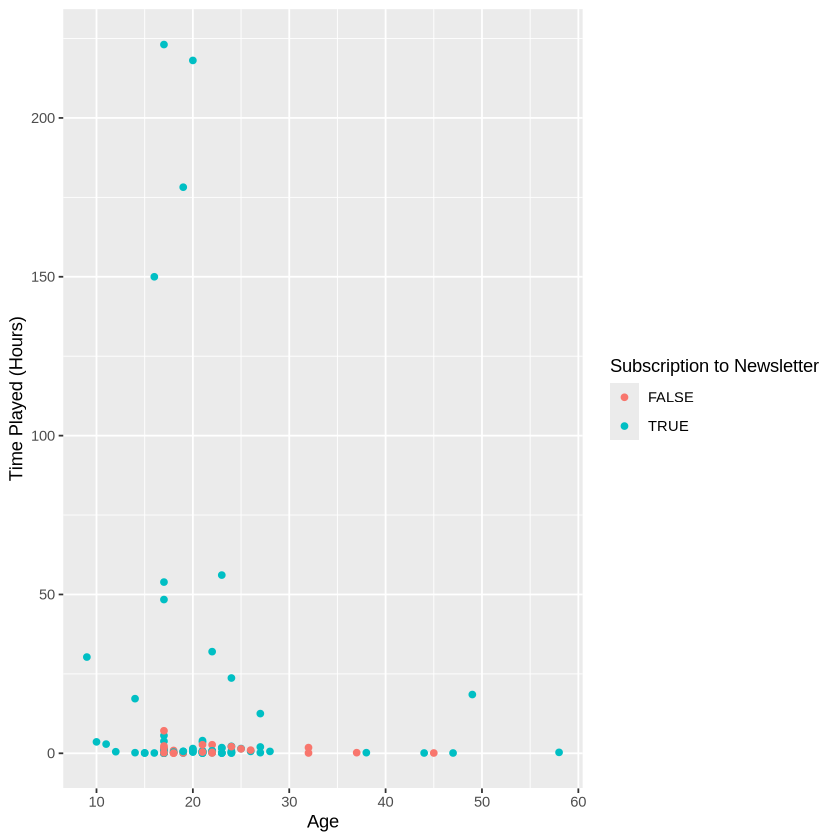

In [26]:
#Check for obvious relationship

players_select <- players_clean |>
    select(Age, subscribe, played_hours)

players_plot <- players_select |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe))+
    geom_point()+
    labs(x = "Age", y = "Time Played (Hours)", color = "Subscription to Newsletter")
players_plot

In [54]:
#Split the data into training and testing
set.seed(5678)

subscribe_split <- initial_split(players_select, prop = 0.75, strata = subscribe)

subscribe_training <- training(subscribe_split)
subscribe_testing <- testing(subscribe_split)

In [55]:
#Specification and Recipe for KNN Regression
set.seed(5678)
subscribe_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")

subscribe_recipe <- recipe(subscribe ~ Age + played_hours, data = subscribe_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

subscribe_vfold <- vfold_cv(data = subscribe_training, v = 5, strata = subscribe)

gridvals <- tibble(neighbors = seq(from = 1, to = 41, by = 2))

In [56]:
#Find the best k value for knn classification using collect_metrics
set.seed(5678)
subscribe_results <- workflow()|>
    add_recipe(subscribe_recipe)|>
    add_model(subscribe_spec)|>
    tune_grid(resamples = subscribe_vfold, grid = gridvals)|>
    collect_metrics()|>
    filter(.metric == "accuracy")

subscribe_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6368627,5,0.062531499,Preprocessor1_Model01
3,accuracy,binary,0.6666667,5,0.023659770,Preprocessor1_Model02
5,accuracy,binary,0.6917647,5,0.053892684,Preprocessor1_Model03
7,accuracy,binary,0.8039216,5,0.019251667,Preprocessor1_Model04
9,accuracy,binary,0.7921569,5,0.019841742,Preprocessor1_Model05
11,accuracy,binary,0.7921569,5,0.019841742,Preprocessor1_Model06
13,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model07
15,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model08
17,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.8039216,5,0.019251667,Preprocessor1_Model04
9,accuracy,binary,0.7921569,5,0.019841742,Preprocessor1_Model05
11,accuracy,binary,0.7921569,5,0.019841742,Preprocessor1_Model06
13,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model07
15,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model08
17,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model09


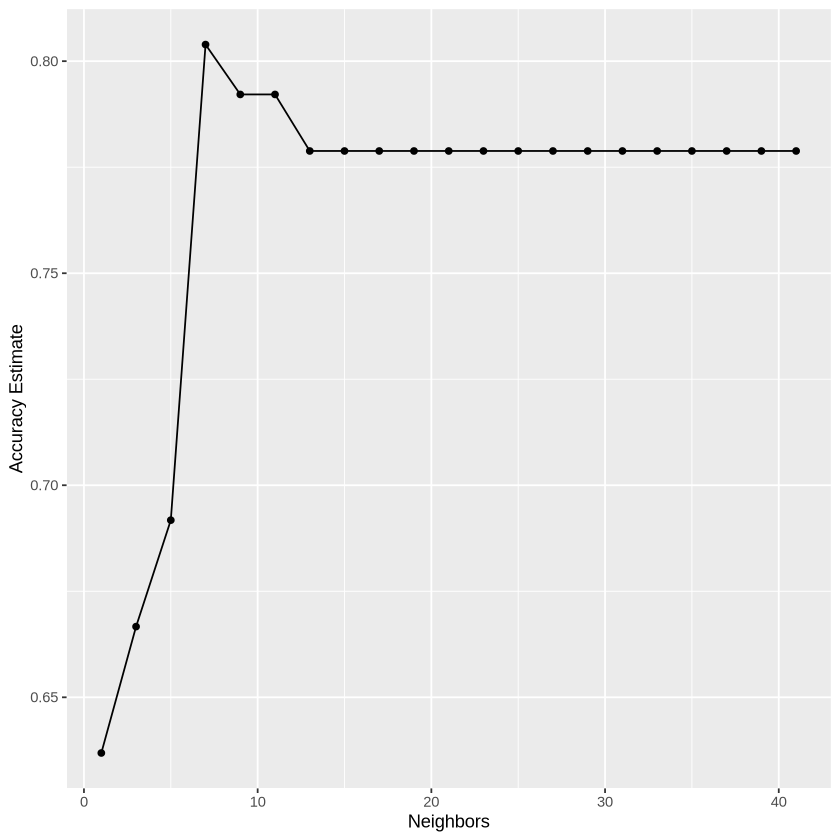

In [74]:
#Plot the results from the last cell and use the elbow to find the best k value
set.seed(5678)
elbow_plot <- subscribe_results |>
    ggplot(aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate") 
                       
elbow_plot

best_k <- arrange(subscribe_results, desc(mean))
head(best_k)

In [69]:
#From the Elbow plot above, we determine that the best k value is 7
#After a k value of 5, there is a decline then a plateauafter 11

In [58]:
#Build new model with better k value
set.seed(5678)
best_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7)|>
    set_engine("kknn")|>
    set_mode("classification")

subscribe_best_wf <- workflow()|>
    add_model(best_k_spec)|>
    add_recipe(subscribe_recipe)

subscribe_fit <- fit(best_k_spec, subscribe ~ Age + played_hours, data = subscribe_training)

In [59]:
#Apply new model to predict class for testing set
set.seed(5678)
subscribe_predictions <- predict(subscribe_fit, subscribe_testing)|>
    bind_cols(subscribe_testing)|>
    mutate(.pred_class = as_factor(.pred_class))
subscribe_predictions

sub_metrics <- subscribe_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)|>
    filter(.metric == "accuracy")
sub_metrics

conf_mat <- subscribe_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
conf_mat

.pred_class,Age,subscribe,played_hours
<fct>,<dbl>,<fct>,<dbl>
TRUE,9,TRUE,30.3
TRUE,17,TRUE,3.8
TRUE,17,FALSE,0.1
TRUE,28,TRUE,0.6
TRUE,23,TRUE,1.8
FALSE,18,FALSE,0.1
TRUE,20,TRUE,0.4
TRUE,17,TRUE,0.2
TRUE,17,TRUE,0.1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7857143


          Truth
Prediction FALSE TRUE
     FALSE     1    0
     TRUE      6   21

Check for github

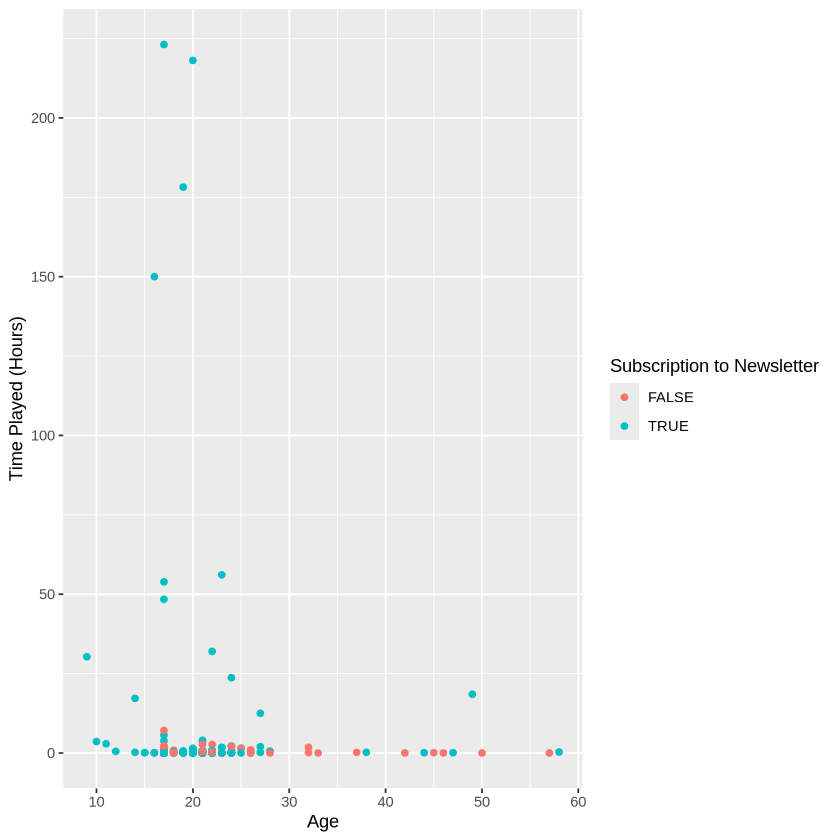

In [39]:
#Alternative model including the datapoints where time = 0
players_2 <- players |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter( !Age == "NA") 

players_select_2 <- players_2 |>
    select(Age, subscribe, played_hours)

players_2_plot <- players_select_2 |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe))+
    geom_point()+
    labs(x = "Age", y = "Time Played (Hours)", color = "Subscription to Newsletter")
players_2_plot


In [64]:
#build new model
set.seed(5678)

subscribe_split_2 <- initial_split(players_select, prop = 0.75, strata = subscribe)

subscribe_training_2 <- training(subscribe_split_2)
subscribe_testing_2 <- testing(subscribe_split_2)

set.seed(5678)
subscribe_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")

subscribe_recipe_2 <- recipe(subscribe ~ Age + played_hours, data = subscribe_training_2)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

subscribe_vfold_2 <- vfold_cv(data = subscribe_training_2, v = 5, strata = subscribe)

gridvals <- tibble(neighbors = seq(from = 1, to = 41, by = 2))

In [65]:
set.seed(5678)
subscribe_results_2 <- workflow()|>
    add_recipe(subscribe_recipe_2)|>
    add_model(subscribe_spec)|>
    tune_grid(resamples = subscribe_vfold_2, grid = gridvals)|>
    collect_metrics()|>
    filter(.metric == "accuracy")

subscribe_results_2

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6368627,5,0.062531499,Preprocessor1_Model01
3,accuracy,binary,0.6666667,5,0.023659770,Preprocessor1_Model02
5,accuracy,binary,0.6917647,5,0.053892684,Preprocessor1_Model03
7,accuracy,binary,0.8039216,5,0.019251667,Preprocessor1_Model04
9,accuracy,binary,0.7921569,5,0.019841742,Preprocessor1_Model05
11,accuracy,binary,0.7921569,5,0.019841742,Preprocessor1_Model06
13,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model07
15,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model08
17,accuracy,binary,0.7788235,5,0.008645258,Preprocessor1_Model09


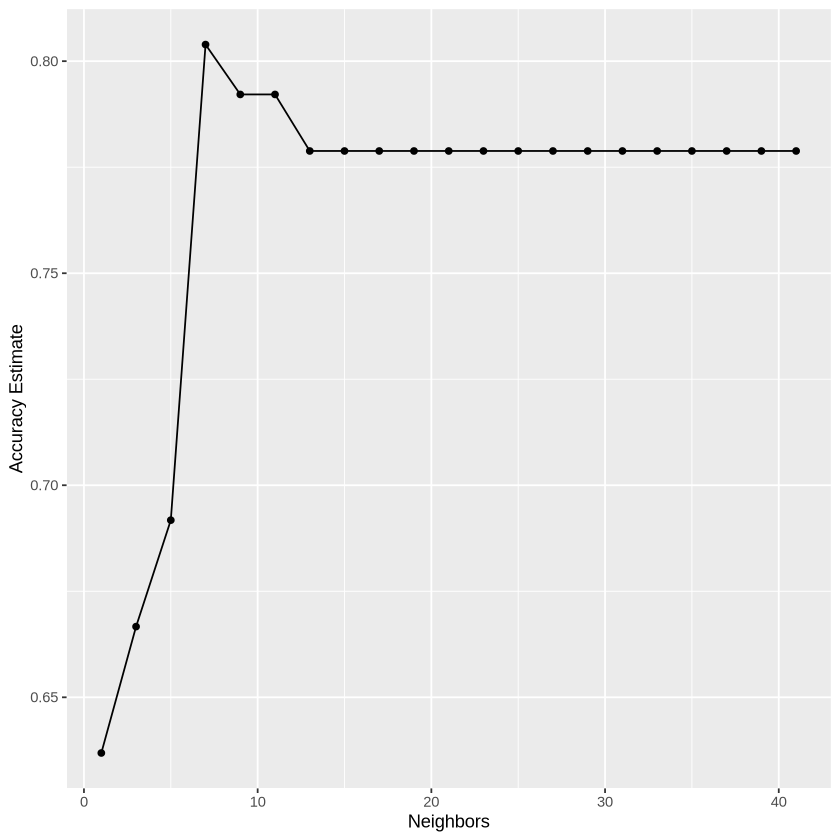

In [67]:
#New elbow plot, lets see if best k changed
elbow_plot_2<- subscribe_results_2 |>
    ggplot(aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate") 
                       
elbow_plot_2

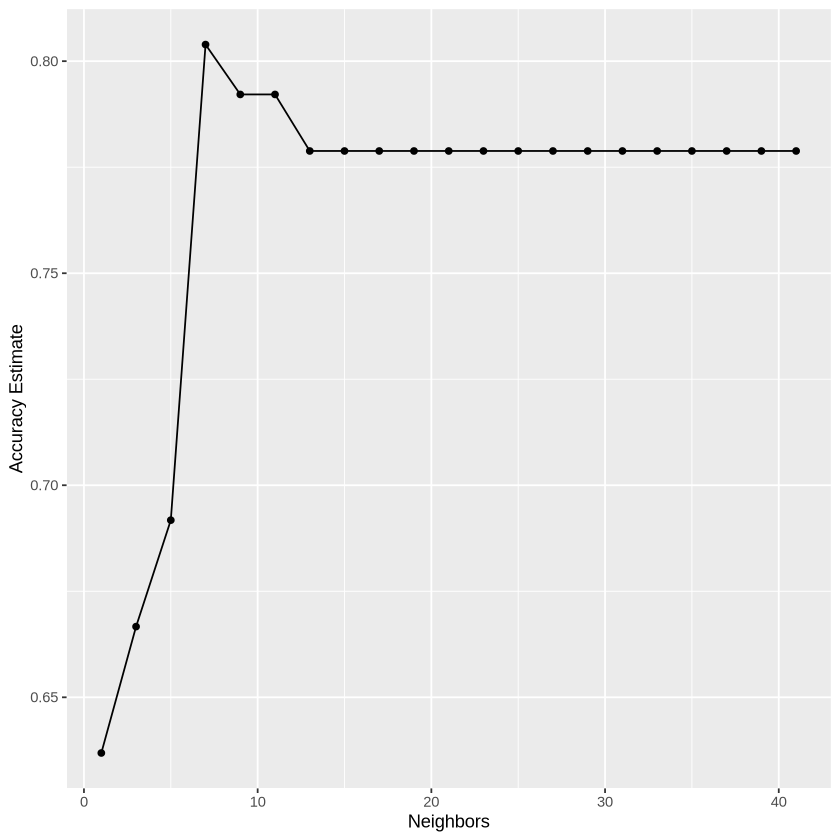

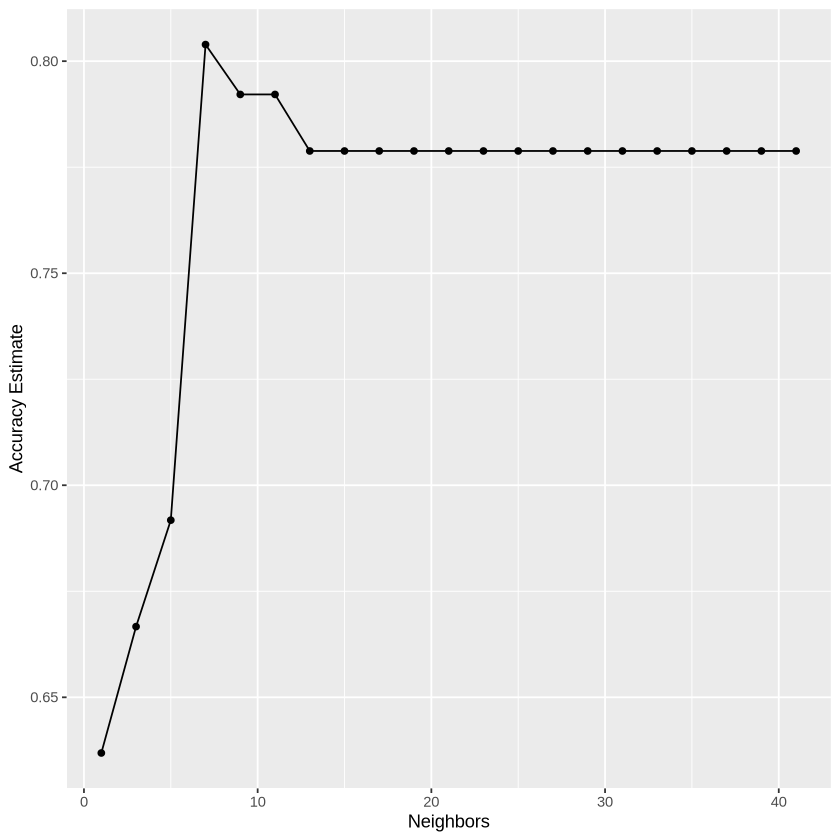

In [68]:
#Check to see if theyre the same
elbow_plot
elbow_plot_2

In [71]:
#Still, lets see if its more accurate 
set.seed(5678)
best_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7)|>
    set_engine("kknn")|>
    set_mode("classification")

subscribe_best_wf_2 <- workflow()|>
    add_model(best_k_spec)|>
    add_recipe(subscribe_recipe_2)

subscribe_fit_2 <- fit(best_k_spec, subscribe ~ Age + played_hours, data = subscribe_training_2)

subscribe_predictions_2 <- predict(subscribe_fit_2, subscribe_testing_2)|>
    bind_cols(subscribe_testing_2)|>
    mutate(.pred_class = as_factor(.pred_class))
subscribe_predictions_2

sub_metrics_2 <- subscribe_predictions_2 |>
    metrics(truth = subscribe, estimate = .pred_class)|>
    filter(.metric == "accuracy")
sub_metrics_2

conf_mat_2 <- subscribe_predictions_2 |>
    conf_mat(truth = subscribe, estimate = .pred_class)
conf_mat_2

.pred_class,Age,subscribe,played_hours
<fct>,<dbl>,<fct>,<dbl>
TRUE,9,TRUE,30.3
TRUE,17,TRUE,3.8
TRUE,17,FALSE,0.1
TRUE,28,TRUE,0.6
TRUE,23,TRUE,1.8
FALSE,18,FALSE,0.1
TRUE,20,TRUE,0.4
TRUE,17,TRUE,0.2
TRUE,17,TRUE,0.1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7857143


          Truth
Prediction FALSE TRUE
     FALSE     1    0
     TRUE      6   21